1. Project Overview

# Dog Breed Classification with ResNet-50

This notebook demonstrates the process of building a dog breed classification model using the Stanford Dogs Dataset and the ResNet-50 architecture. We'll utilize transfer learning to leverage pre-trained features, fine-tune the model, and evaluate its performance.

## Table of Contents
1. [Imports](#Imports)
2. [Configuration and Hyperparameters](#Configuration-and-Hyperparameters)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Creating Data Loaders](#Creating-Data-Loaders)
5. [Model Definition](#Model-Definition)
6. [Model Visualization](#Model-Visualization)
7. [Defining Loss Function and Optimizer](#Defining-Loss-Function-and-Optimizer)
8. [Training the Model](#Training-the-Model)
9. [Saving the Model](#Saving-the-Model)
10. [Visualizing Training Metrics](#Visualizing-Training-Metrics)
11. [Conclusion](#Conclusion)


2. Imports


In [1]:
# Import Statements
import sys
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchviz import make_dot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import pandas
from torchvision import transforms
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader
import time 
import torchmetrics
from tqdm import tqdm 
import os
import scipy.io
import pandas as pd

## Imports

We begin by importing the necessary libraries and modules. This includes PyTorch for building and training the model, Torchvision for pre-trained models and image transformations, and other utility libraries for data handling and visualization.

**Note:** Ensure that the `mobilenetmodel` module (which contains `data_preprocess`, `create_data_loaders`, `train_model`, and `visualize_training` functions) is available in your working directory or Python path.


3. Configuration and Hyperparameters


## Configuration and Hyperparameters

Here, we define the configuration settings and hyperparameters for our model training:

- **data_dir:** Directory where the Stanford Dogs Dataset is stored.
- **sample_size:** Number of samples to use. Set to `None` to use the entire dataset.
- **batch_size:** Number of samples per batch during training.
- **num_epochs:** Number of training epochs.
- **learning_rate:** Learning rate for the optimizer.
- **num_classes:** Total number of dog breed classes (120).
- **val_split:** Proportion of data reserved for validation.
- **model_save_path:** Directory to save the trained model and optimizer.
- **model_filename & optimizer_filename:** Filenames for saving the model and optimizer states.

We also ensure that the directory for saving models exists.


In [2]:
# Configuration and Hyperparameters
data_dir = 'C:/Users/anujp/Desktop/dog_breed_classification/data/images/Images'  # Path to dataset
sample_size = None  # Use None for full dataset or set to an integer for a subset
batch_size = 64
num_epochs = 20
learning_rate = 0.0003
num_classes = 120  # Number of dog breeds
val_split = 0.05  # 5% of data for validation
model_save_path = os.path.join(data_dir, 'models')
model_filename = 'resnet50_dog_breed.pth'
optimizer_filename = 'resnet50_optimizer.pth'

# Create directories if they don't exist
os.makedirs(model_save_path, exist_ok=True)


4. Data Preprocessing


In [3]:
def data_preprocess(data_dir, mat_path, sample_size=None):
    # Load annotations
    annotations = scipy.io.loadmat(mat_path)
    
    # Extract file paths and labels
    file_list = [str(f[0][0]).replace("//", "/") for f in annotations['file_list']]  # Replace backslashes with forward slashes
    # labels = [int(l[0]) for l in annotations['labels']]
    labels = [int(l[0] - 1) for l in annotations['labels']]  # Subtract 1 from each label

    
    # Create DataFrame
    labels_df = pd.DataFrame({
        'file_path': file_list, 
        'label': labels        
    })
    
    # Construct full paths to images
    images_dir = os.path.join(data_dir, "images", "Images").replace("//", "/")
    labels_df['full_path'] = labels_df['file_path'].apply(
        lambda x: os.path.join(images_dir, x).replace("\\", "/")
    )
    
    # Verify if files exist
    labels_df['file_exists'] = labels_df['full_path'].apply(os.path.exists)
    print(f"Files found: {labels_df['file_exists'].sum()} out of {len(labels_df)}")
    
    # Keep only existing files
    labels_df = labels_df[labels_df['file_exists']].copy()
    
    # Filter by sample size (optional)
    if sample_size:
        labels_df = labels_df.sample(sample_size, random_state=42)
    
    print(f"Dataset Statistics:\nTotal images: {len(labels_df)}\nClasses: {len(labels_df['label'].unique())}")
    print(labels_df.head())
    
    return labels_df[['full_path', 'label']]

# Usage Example
data_dir = "C:/Users/anujp/Desktop/dog_breed_classification/data"
mat_path = os.path.join(data_dir, "lists", "file_list.mat").replace("\\", "/")  # Use forward slashes
sample_size = None  # Adjust as needed

frame_lbl = data_preprocess(data_dir, mat_path, sample_size)

print("\nDataFrame Head:")
print(frame_lbl.head())


Files found: 20580 out of 20580
Dataset Statistics:
Total images: 20580
Classes: 120
                                 file_path  label  \
0  n02085620-Chihuahua/n02085620_10074.jpg      0   
1  n02085620-Chihuahua/n02085620_10131.jpg      0   
2  n02085620-Chihuahua/n02085620_10621.jpg      0   
3   n02085620-Chihuahua/n02085620_1073.jpg      0   
4  n02085620-Chihuahua/n02085620_10976.jpg      0   

                                           full_path  file_exists  
0  C:/Users/anujp/Desktop/dog_breed_classificatio...         True  
1  C:/Users/anujp/Desktop/dog_breed_classificatio...         True  
2  C:/Users/anujp/Desktop/dog_breed_classificatio...         True  
3  C:/Users/anujp/Desktop/dog_breed_classificatio...         True  
4  C:/Users/anujp/Desktop/dog_breed_classificatio...         True  

DataFrame Head:
                                           full_path  label
0  C:/Users/anujp/Desktop/dog_breed_classificatio...      0
1  C:/Users/anujp/Desktop/dog_breed_classificatio..

In [4]:
from PIL import Image
from torch.utils.data import Dataset

class loader_image(Dataset):
    def __init__(self, dataframe, transform=None, test=False):
        self.data = dataframe.values  # Convert DataFrame to NumPy array
        self.transform = transform
        self.test = test

    def __getitem__(self, index):
        # Extract image path and label
        image_path, label = self.data[index]
        image = Image.open(image_path).convert("RGB")  # Ensure image is converted to RGB
        
        if self.transform:
            image = self.transform(image)
        
        # Return image and label (or only image in test mode)
        if self.test:
            return image
        else:
            return image, label

    def __len__(self):
        return len(self.data)


In [5]:
def create_data_loaders(frame_lbl, batch_size, val_split):
    # Create transformers
    tf_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    tf_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Split the dataset using stratified sampling
    split = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=42)
    
    # Initialize train_df and val_df
    train_df = None
    val_df = None
    
    for train_idx, val_idx in split.split(frame_lbl, frame_lbl['label']):
        train_df = frame_lbl.loc[train_idx]
        val_df = frame_lbl.loc[val_idx]

    # Create datasets
    training_set = loader_image(train_df, transform=tf_train)
    validation_set = loader_image(val_df, transform=tf_val)

    # Create dataloaders
    dataloader_train = DataLoader(
        training_set, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    dataloader_validation = DataLoader(
        validation_set, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    print(f'Training set: {len(train_df)}, Validation set: {len(val_df)}')
    
    # Return the dataloaders
    return dataloader_train, dataloader_validation

In [6]:
# Create Data Loaders
dataloader_train, dataloader_validation = create_data_loaders(frame_lbl, batch_size, val_split=val_split)

# Display the number of batches
print(f"Number of training batches: {len(dataloader_train)}")
print(f"Number of validation batches: {len(dataloader_validation)}")


Training set: 19551, Validation set: 1029
Number of training batches: 306
Number of validation batches: 17


In [7]:
class CNN(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CNN, self).__init__()
        self.base_model = base_model
        
        # Remove the last layer of ResNet
        self.base_model.fc = nn.Identity()
        
        # Add new classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),  # ResNet50's output is 2048
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

In [8]:
def create_model(num_classes):
    # Load the pre-trained ResNet50
    resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
    
    # Freeze the base model parameters
    for param in resnet.parameters():
        param.requires_grad = False
    
    # Create the model
    model = CNN(resnet, num_classes)
    
    # Move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)
    
    return model, device

In [14]:
# Define Loss Function and Optimizer
# CrossEntropyLoss is suitable for multi-class classification

model, device = create_model(num_classes)

loss_fn = nn.CrossEntropyLoss()

# Use only trainable parameters (those with requires_grad=True)
trainable_params = filter(lambda p: p.requires_grad, model.parameters())

# Define the optimizer
optimizer = optim.Adam(trainable_params, lr=learning_rate)

# Display optimizer and loss function
print(f"Loss Function: {loss_fn}")
print(f"Optimizer: {optimizer}")


cuda
Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)


In [15]:
def train_model(train_loader, val_loader, device, model, criterion, optimizer, epochs):
    print("Starting training process...")
    print(f"Training on device: {device}")
    
    # Lists for tracking metrics
    metrics = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'learning_rates': [],
        'training_times': []
    }

    # Initialize metrics tracking
    train_acc_metric = torchmetrics.Accuracy(num_classes=120, average='macro', task='multiclass').to(device)
    val_acc_metric = torchmetrics.Accuracy(num_classes=120, average='macro', task='multiclass').to(device)
    
    # Initialize best model tracking
    best_val_loss = float('inf')
    best_val_acc = 0.0
    
    try:
        for epoch in range(epochs):
            start_time = time.time()
            current_lr = optimizer.param_groups[0]['lr']
            metrics['learning_rates'].append(current_lr)
            
            # Training Phase
            model.train()
            train_batch_losses = []
            
            # Progress tracking
            train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
            
            for batch_idx, (inputs, targets) in enumerate(train_progress):
                try:
                    # Clear GPU cache periodically
                    if batch_idx % 100 == 0 and torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    
                    # Verify data ranges
                    assert targets.min() >= 0 and targets.max() < 120, \
                        f"Target values out of range: min={targets.min()}, max={targets.max()}"
                    
                    # Move data to device
                    inputs, targets = inputs.to(device), targets.to(device)
                    
                    # Forward pass
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    # Backward pass
                    loss.backward()
                    optimizer.step()
                    
                    # Track metrics
                    train_batch_losses.append(loss.item())
                    train_acc_metric.update(outputs, targets)
                    
                    # Update progress bar
                    train_progress.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'gpu_mem': f'{torch.cuda.memory_allocated()/1024**2:.1f}MB' if torch.cuda.is_available() else 'N/A'
                    })
                    
                except RuntimeError as e:
                    print(f"\nError in training batch {batch_idx}:")
                    print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
                    print(f"Target range: {targets.min()}-{targets.max()}")
                    raise e

            # Validation Phase
            model.eval()
            val_batch_losses = []
            val_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            
            with torch.no_grad():
                for inputs, targets in val_progress:
                    try:
                        inputs, targets = inputs.to(device), targets.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        val_batch_losses.append(loss.item())
                        val_acc_metric.update(outputs, targets)
                        
                        val_progress.set_postfix({'loss': f'{loss.item():.4f}'})
                        
                    except RuntimeError as e:
                        print(f"\nError in validation batch:")
                        print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
                        raise e

            # Calculate metrics
            train_loss = sum(train_batch_losses) / len(train_batch_losses)
            val_loss = sum(val_batch_losses) / len(val_batch_losses)
            train_acc = train_acc_metric.compute().item()
            val_acc = val_acc_metric.compute().item()
            epoch_time = time.time() - start_time

            # Store metrics
            metrics['train_losses'].append(train_loss)
            metrics['val_losses'].append(val_loss)
            metrics['train_accuracies'].append(train_acc)
            metrics['val_accuracies'].append(val_acc)
            metrics['training_times'].append(epoch_time)

            # Reset metrics
            train_acc_metric.reset()
            val_acc_metric.reset()

            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{epochs} Summary:")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            print(f"Time: {epoch_time:.2f}s")

            # Save best model
            if val_loss < best_val_loss or val_acc > best_val_acc:
                best_val_loss = min(val_loss, best_val_loss)
                best_val_acc = max(val_acc, best_val_acc)
                
                # Save model with timestamp
                timestamp = time.strftime("%Y%m%d_%H%M%S")
                save_path = f'best_model_{timestamp}.pth'
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_acc': val_acc,
                }, save_path)
                
                print(f"Saved best model to {save_path}")
                print(f"Best Val Loss: {best_val_loss:.4f}, Best Val Acc: {best_val_acc:.4f}")
            
            # Optional: Early stopping check could be added here
            
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    except Exception as e:
        print(f"\nAn error occurred during training: {str(e)}")
        raise e
    finally:
        # Clean up
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return metrics

# Training execution
try:
    print("Initializing training...")
    print(f"Total training batches: {len(dataloader_train)}")
    print(f"Total validation batches: {len(dataloader_validation)}")
    
    # Clear GPU memory before training
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"Initial GPU memory usage: {torch.cuda.memory_allocated()/1024**2:.1f}MB")
    
    metrics = train_model(
        dataloader_train,
        dataloader_validation,
        device,
        model,
        loss_fn,
        optimizer,
        num_epochs
    )
    
    print("Training completed successfully!")
    
except Exception as e:
    print(f"An error occurred during training setup: {str(e)}")
    raise e

Initializing training...
Total training batches: 306
Total validation batches: 17
Initial GPU memory usage: 94.1MB
Starting training process...
Training on device: cuda


Epoch 1/20 [Val]: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s, loss=0.8982]



Epoch 1/20 Summary:
Train Loss: 2.9326, Train Acc: 0.3612
Val Loss: 0.9860, Val Acc: 0.7640
Time: 310.16s
Saved best model to best_model_20241225_233407.pth
Best Val Loss: 0.9860, Best Val Acc: 0.7640


Epoch 2/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s, loss=0.6723]



Epoch 2/20 Summary:
Train Loss: 1.5422, Train Acc: 0.5930
Val Loss: 0.6604, Val Acc: 0.8228
Time: 247.40s
Saved best model to best_model_20241225_233815.pth
Best Val Loss: 0.6604, Best Val Acc: 0.8228


Epoch 3/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.55it/s, loss=0.4121]



Epoch 3/20 Summary:
Train Loss: 1.3432, Train Acc: 0.6304
Val Loss: 0.5663, Val Acc: 0.8233
Time: 97.21s
Saved best model to best_model_20241225_233952.pth
Best Val Loss: 0.5663, Best Val Acc: 0.8233


Epoch 4/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.53it/s, loss=0.3882]



Epoch 4/20 Summary:
Train Loss: 1.2636, Train Acc: 0.6493
Val Loss: 0.5021, Val Acc: 0.8421
Time: 97.18s
Saved best model to best_model_20241225_234129.pth
Best Val Loss: 0.5021, Best Val Acc: 0.8421


Epoch 5/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.52it/s, loss=0.4113]



Epoch 5/20 Summary:
Train Loss: 1.2370, Train Acc: 0.6564
Val Loss: 0.4798, Val Acc: 0.8463
Time: 96.31s
Saved best model to best_model_20241225_234306.pth
Best Val Loss: 0.4798, Best Val Acc: 0.8463


Epoch 6/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.49it/s, loss=0.6306]



Epoch 6/20 Summary:
Train Loss: 1.2028, Train Acc: 0.6657
Val Loss: 0.4741, Val Acc: 0.8482
Time: 96.13s
Saved best model to best_model_20241225_234442.pth
Best Val Loss: 0.4741, Best Val Acc: 0.8482


Epoch 7/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.53it/s, loss=0.2537]



Epoch 7/20 Summary:
Train Loss: 1.1729, Train Acc: 0.6722
Val Loss: 0.4430, Val Acc: 0.8554
Time: 96.42s
Saved best model to best_model_20241225_234618.pth
Best Val Loss: 0.4430, Best Val Acc: 0.8554


Epoch 8/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.51it/s, loss=0.4065]



Epoch 8/20 Summary:
Train Loss: 1.1710, Train Acc: 0.6732
Val Loss: 0.4585, Val Acc: 0.8542
Time: 96.04s


Epoch 9/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.52it/s, loss=0.3942]



Epoch 9/20 Summary:
Train Loss: 1.1423, Train Acc: 0.6802
Val Loss: 0.4532, Val Acc: 0.8561
Time: 103.69s
Saved best model to best_model_20241225_234938.pth
Best Val Loss: 0.4430, Best Val Acc: 0.8561


Epoch 10/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.53it/s, loss=0.3593]



Epoch 10/20 Summary:
Train Loss: 1.1438, Train Acc: 0.6778
Val Loss: 0.4536, Val Acc: 0.8514
Time: 95.78s


Epoch 11/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.54it/s, loss=0.4351]



Epoch 11/20 Summary:
Train Loss: 1.1204, Train Acc: 0.6863
Val Loss: 0.4634, Val Acc: 0.8561
Time: 95.60s


Epoch 12/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.50it/s, loss=0.2170]



Epoch 12/20 Summary:
Train Loss: 1.1056, Train Acc: 0.6907
Val Loss: 0.4333, Val Acc: 0.8616
Time: 97.54s
Saved best model to best_model_20241225_235427.pth
Best Val Loss: 0.4333, Best Val Acc: 0.8616


Epoch 13/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.50it/s, loss=0.3552]



Epoch 13/20 Summary:
Train Loss: 1.1048, Train Acc: 0.6878
Val Loss: 0.4187, Val Acc: 0.8679
Time: 96.07s
Saved best model to best_model_20241225_235603.pth
Best Val Loss: 0.4187, Best Val Acc: 0.8679


Epoch 14/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.52it/s, loss=0.2467]



Epoch 14/20 Summary:
Train Loss: 1.1142, Train Acc: 0.6856
Val Loss: 0.4196, Val Acc: 0.8646
Time: 95.89s


Epoch 15/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.50it/s, loss=0.3912]



Epoch 15/20 Summary:
Train Loss: 1.0847, Train Acc: 0.6948
Val Loss: 0.4342, Val Acc: 0.8615
Time: 95.61s


Epoch 16/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.51it/s, loss=0.4356]



Epoch 16/20 Summary:
Train Loss: 1.0893, Train Acc: 0.6947
Val Loss: 0.4189, Val Acc: 0.8583
Time: 95.75s


Epoch 17/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.54it/s, loss=0.6164]



Epoch 17/20 Summary:
Train Loss: 1.0714, Train Acc: 0.6993
Val Loss: 0.4262, Val Acc: 0.8603
Time: 95.98s


Epoch 18/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.54it/s, loss=0.3496]



Epoch 18/20 Summary:
Train Loss: 1.0652, Train Acc: 0.6977
Val Loss: 0.4221, Val Acc: 0.8594
Time: 97.14s


Epoch 19/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.53it/s, loss=0.3859]



Epoch 19/20 Summary:
Train Loss: 1.0582, Train Acc: 0.7024
Val Loss: 0.4150, Val Acc: 0.8600
Time: 105.88s
Saved best model to best_model_20241226_000550.pth
Best Val Loss: 0.4150, Best Val Acc: 0.8679


Epoch 20/20 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.51it/s, loss=0.4175]


Epoch 20/20 Summary:
Train Loss: 1.0723, Train Acc: 0.7014
Val Loss: 0.4066, Val Acc: 0.8668
Time: 96.03s
Saved best model to best_model_20241226_000726.pth
Best Val Loss: 0.4066, Best Val Acc: 0.8679
Training completed successfully!


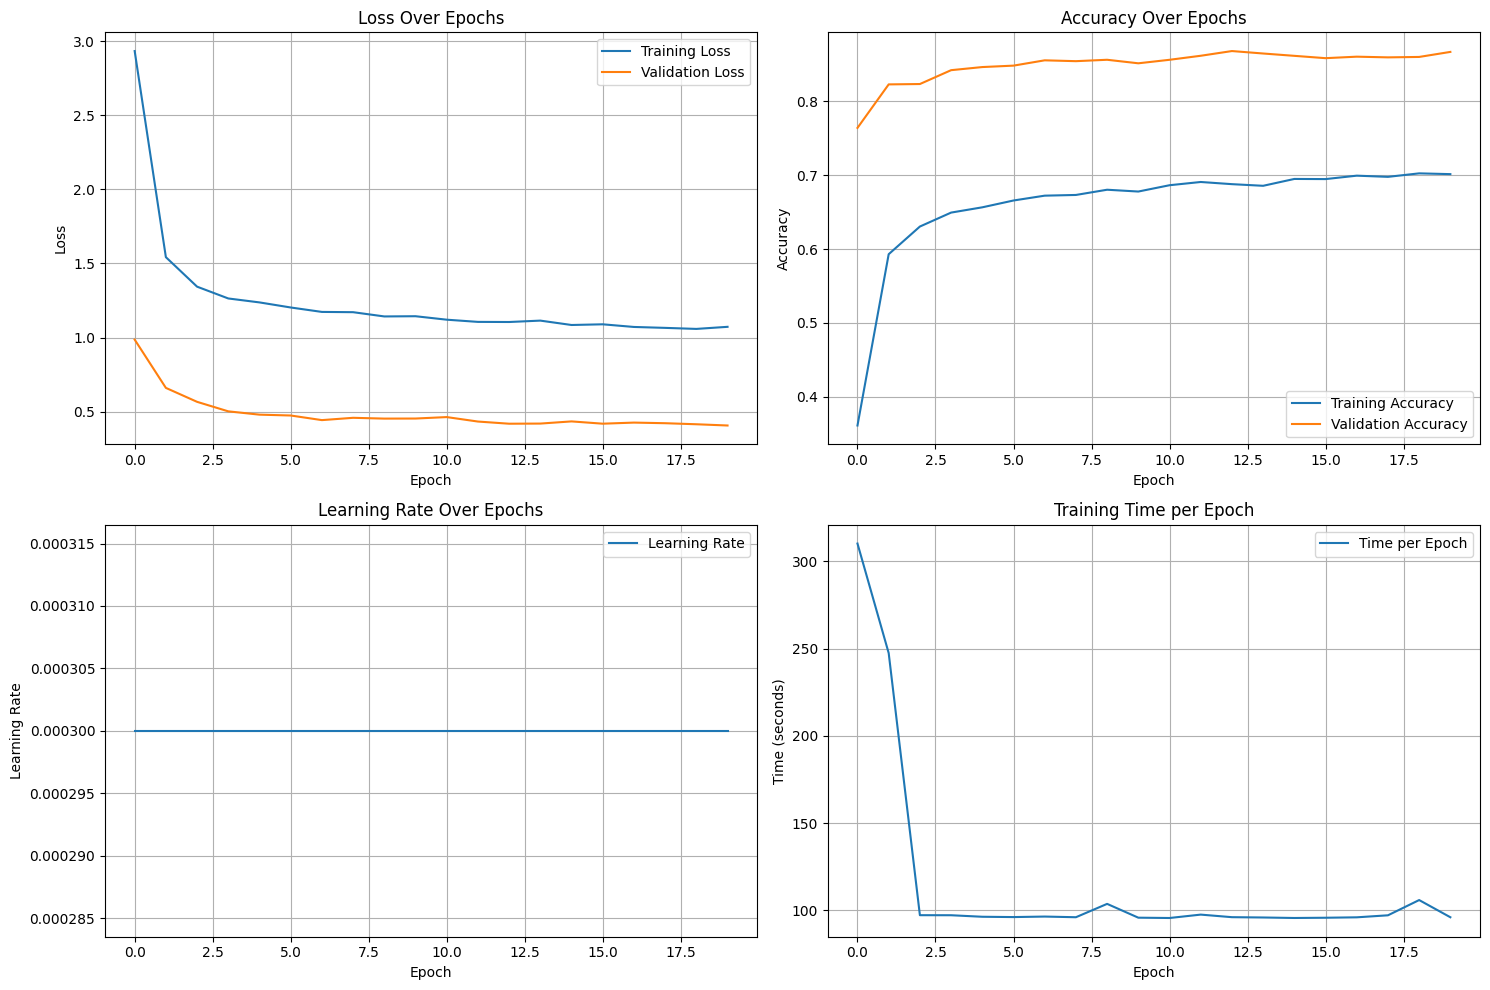

Plots have been saved successfully!


In [16]:
def plot_training_metrics(metrics):
    import matplotlib.pyplot as plt
    
    # Create figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot Training and Validation Loss
    ax1.plot(metrics['train_losses'], label='Training Loss')
    ax1.plot(metrics['val_losses'], label='Validation Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot Training and Validation Accuracy
    ax2.plot(metrics['train_accuracies'], label='Training Accuracy')
    ax2.plot(metrics['val_accuracies'], label='Validation Accuracy')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Plot Learning Rate
    ax3.plot(metrics['learning_rates'], label='Learning Rate')
    ax3.set_title('Learning Rate Over Epochs')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.legend()
    ax3.grid(True)
    
    # Plot Training Times
    ax4.plot(metrics['training_times'], label='Time per Epoch')
    ax4.set_title('Training Time per Epoch')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Time (seconds)')
    ax4.legend()
    ax4.grid(True)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    plt.savefig('training_metrics.png')
    plt.close()

# Function for plotting a single metric
def plot_metric(metric_name, values, title, xlabel='Epoch', ylabel=None):
    plt.figure(figsize=(10, 6))
    plt.plot(values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel if ylabel else metric_name)
    plt.grid(True)
    plt.savefig(f'{metric_name.lower()}_plot.png')
    plt.close()

# After training completes, use the metrics dictionary to create plots
try:
    # Create overall metrics plot
    plot_training_metrics(metrics)
    
    # Create individual metric plots
    plot_metric('Loss', metrics['train_losses'], 'Training Loss Over Time')
    plot_metric('Accuracy', metrics['train_accuracies'], 'Training Accuracy Over Time', ylabel='Accuracy (%)')
    
    print("Plots have been saved successfully!")
    
except Exception as e:
    print(f"Error creating plots: {str(e)}")

In [20]:
def load_model_for_inference(model_path, device):
    # Load the pre-trained ResNet50
    resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
    
    # Create model with same architecture
    model = CNN(resnet, num_classes=120)
    model = model.to(device)
    
    # Load the trained weights
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Set to evaluation mode
    model.eval()
    return model

def predict_image(model, image_path, device):
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Load image and apply transforms
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0]
        
    return predicted.item(), confidence[predicted].item()

# Usage example:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'C:/Users/anujp/Desktop/dog_breed_classification/best_model_20241226_000726.pth'  # Replace with your saved model path
model = load_model_for_inference(model_path, device)

# Test on a single image
image_path = 'C:/Users/anujp/Desktop/dog_breed_classification/data/images/Images/n02106550-Rottweiler/n02106550_3886.jpg'  # Replace with your test image path
#C:\Users\anujp\Desktop\dog_breed_classification\data\images\Images\
predicted_class, confidence = predict_image(model, image_path, device)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

C:\Users\anujp\AppData\Local\Temp\ipykernel_25448\1995988774.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Predicted class: 83
Confidence: 0.96


In [ ]:
def get_breed_names(mat_path):
    # Load annotations
    annotations = scipy.io.loadmat(mat_path)
    
    # Print available keys to debug
    print("Available keys in mat file:", annotations.keys())
    
    # Get the first file path and extract breed name from it
    file_list = [str(f[0][0]) for f in annotations['file_list']]
    
    # Extract unique breed names from file paths
    breed_names = []
    for file_path in file_list:
        # Extract breed name from path (assuming format: nXXXXXXXX-breed_name/...)
        breed = file_path.split('/')[0].split('-')[-1]
        if breed not in breed_names:
            breed_names.append(breed)
    
    return breed_names

def predict_image_with_breed(model, image_path, device, breed_names):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    image = image.to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0]
        
        # Get top-5 predictions
        top5_conf, top5_pred = torch.topk(confidence, 5)
        top5_results = [(breed_names[idx], conf.item()) for idx, conf in zip(top5_pred, top5_conf)]
        
    return top5_results

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'C:/Users/anujp/Desktop/dog_breed_classification/best_model_20241226_000726.pth'
mat_path = "C:/Users/anujp/Desktop/dog_breed_classification/data/lists/file_list.mat"

# Load model and breed names
model = load_model_for_inference(model_path, device)
breed_names = get_breed_names(mat_path)
print("\nFound", len(breed_names), "breeds:")
print(breed_names[:5], "...") # Print first 5 breeds as example

# Test image
image_path = 'C:/Users/anujp/Desktop/dog_breed_classification/data/images/Images/n02115641-dingo/n02115641_136.jpg'
#data\images\Images\
#C:\Users\anujp\Desktop\dog_breed_classification\data\images\Images\n02115641-dingo\n02115641_136.jpg

# Get predictions
predictions = predict_image_with_breed(model, image_path, device, breed_names)

# Print results
print("\nPredictions:")
print("-" * 50)
for i, (breed, confidence) in enumerate(predictions, 1):
    print(f"{i}. Breed: {breed}")
    print(f"   Confidence: {confidence*100:.2f}%")
    print("-" * 50)

C:\Users\anujp\AppData\Local\Temp\ipykernel_25448\1995988774.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Available keys in mat file: dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])

Found 119 breeds:
['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Tzu'] ...


IndexError: list index out of range